# Face mask detection (image processing) with Tensorflow/Keras

This is the first phase of project to detect facemask on realtime video. Here we are building model to detect face mask specifically on face images with Keras/ Tensorflow. Second part of project would be first detecting face in the image and then apply mask detection model to detect if the person is wearing mask or not. Lastly, we apply similar logic to detect face mask on real time streaming video.
(ref - https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2

### Image dataset
We have total of 1376 face images with 690 images with mask and rest being without masks. The images are located in dataset folder. 
The images for training and testing are downloaded from https://github.com/prajnasb/observations. 
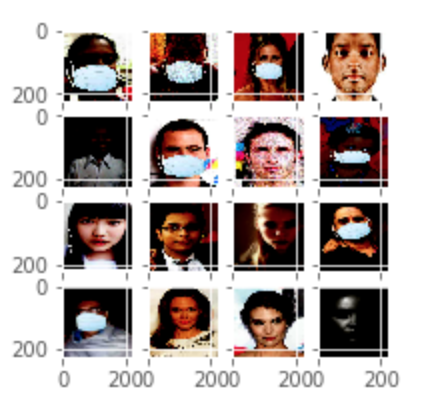

### Image processing and building train-test dataset

In [3]:
data = []
labels = []
dir_with_mask = "/Users/ketki.potdar/mask-detection/dataset/with_mask"
for subdir, dirs, files in os.walk(dir_with_mask):
    for filename in files:
        if filename.endswith(".jpg") or filename.endswith(".png"):
            label = 1
            image = load_img(os.path.join(dir_with_mask, filename), target_size=(224,224))
            image = img_to_array(image)
            image = preprocess_input(image)
            data.append(image)
            labels.append(label)
        else:
            continue
print(len(data))

690


In [4]:
dir_without_mask = "/Users/ketki.potdar/mask-detection/dataset/without_mask"
for subdir, dirs, files in os.walk(dir_without_mask):
    for filename in files:
        if filename.endswith(".jpg") or filename.endswith(".png"):
            label = 0
            image = load_img(os.path.join(dir_without_mask, filename), target_size=(224,224))
            image = img_to_array(image)
            image = preprocess_input(image)
            data.append(image)
            labels.append(label)
        else:
            continue
print(len(data))

1376


In [5]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [6]:
idx = np.random.permutation(len(data))
x = data[idx]
y = labels[idx]

In [7]:
lb = LabelBinarizer()
y = lb.fit_transform(y)
y = to_categorical(y)

In [8]:
(trainX, testX, trainY, testY) = train_test_split(x, y, test_size=0.20, stratify=y, random_state=42)

During training, we augment image dataset by applying mutations on the fly to generalize model better.

In [9]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

We are using MobileNet V2 architecture(https://arxiv.org/abs/1801.04381) as our base model with pretrained weights. On top of it, we are building dense network which would be trained and fine tuned. The training takes ~5 mins on my mac pro.

In [11]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, 
    input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

/anaconda3/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [12]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [13]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
  ...
    to  
  ['...']
Train for 34 steps, validate on 276 samples
Epoch 1/20
34/34 [==============================] - 36s 1s/step - loss: 0.7256 - accuracy: 0.6039 - val_loss: 0.5541 - val_accuracy: 0.6094
Epoch 2/20
34/34 [==============================] - 35s 1s/step - loss: 0.4550 - accuracy: 0.7828 - val_loss: 0.3834 - val_accuracy: 0.7461
Epoch 3/20
34/34 [==============================] - 35s 1s/step - loss: 0.3338 - accuracy: 0.8624 - val_loss: 0.2269 - val_accuracy: 0.9258
Epoch 4/20
34/34 [==============================] - 41s 1s/step - loss: 0.2652 - accuracy: 0.8989 - val_loss: 0.2278 - val_accuracy: 0.9023
Epoch 5/20
34/34 [==============================] - 50s 1s/step - loss: 0.2638 - accuracy: 0.8914 - val_loss: 0.1471 - val_accuracy: 0.9648
Epoch 6/20
34/34 [==============================] - 44s 1s/step - loss: 0.2245 - accuracy: 0.9110 - val_loss: 0.1123 - val_accuracy: 0.9727
Epoch 7/20
34/34 [==============================] - 42s 1s/step - l

In [16]:
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

In [24]:
print(classification_report(testY.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       138
           1       0.98      0.99      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



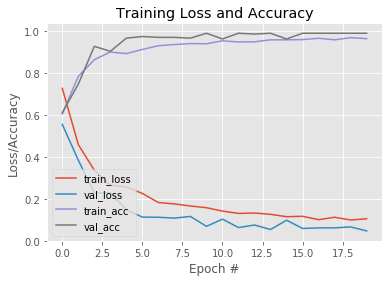

In [35]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [26]:
model.save("tf_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: tf_model/assets
